In [26]:
# use gpd_2023 environment

import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#import seaborn as sns
import pickle
#import torch

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import brier_score_loss

# prob not using here
import pandas as pd
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Configure Matplotlib to use LaTeX and Computer Modern
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
})

In [27]:
def discard_ME_cells(views_vol, un_masked_matrix, feature, month, test_months):

    # Hard coded...
    # For comparison with views 2020 where middle east is not included

    # 0 is ocean
    # You could load in the views replication data and get the c_id for only africa from there... More kosher
    #middle_east_c_id = [ 0.0, 129.0, 130.0, 131.0, 128.0, 132.0, 133.0, 136.0, 55.0, 60.0, 62.0, 89.0, 218.0, 92.0, 220.0, 94.0, 93.0, 96.0, 119.0, 122.0, 124.0, 125.0, 126.0, 127.0]

    middle_east_c_id = [0.0] # for debugging

    # Values to mask (0 and 1 in this example)
    values_to_mask = np.array(middle_east_c_id)

    #for point estimates
    if un_masked_matrix.ndim == 4:

        # Create a mask for the specified values
        mask = np.isin(views_vol[-test_months, :, :, 4], values_to_mask)
        # Mask the array using the created mask
        masked_matrix = np.ma.masked_where(mask, un_masked_matrix[month, feature, :, :]) # [month, feature, :, :] is for the feature, i.e. type of violence

    # for posterior samples
    else:
        mask = np.isin(views_vol[-test_months, :, :, 4], values_to_mask)
        mask = np.broadcast_to(mask[np.newaxis, :, :], un_masked_matrix[:, month, feature, :, :].shape)

        # Mask the array using the created mask
        masked_matrix = np.ma.masked_where(mask, un_masked_matrix[:, month, feature, :, :]) # [month, feature, :, :] is for the feature, i.e. type of violence

    # Get the 1D vector with masked-out values discarded
    #vector = masked_matrix.compressed()

    return masked_matrix #vector

# masked_matrix = discard_ME_cells(mean_class_pred, 0)


In [36]:
def calculate_metrics(i, j, test_months, y_pred_array, y_class_pred_array, out_of_sample_vol, views_vol, metric_dict):

    y_score_masked_matrix = discard_ME_cells(views_vol, y_pred_array, j, i, test_months)
    y_score = y_score_masked_matrix.compressed()

    y_score_prob_masked_matrix = discard_ME_cells(views_vol, y_class_pred_array, j, i, test_months)
    y_score_prob = y_score_prob_masked_matrix.compressed()

    metric_dict = {"monthly/out_sample_month": i}

    y_true_masked_matrix = discard_ME_cells(views_vol, out_of_sample_vol.squeeze(), j, i, test_months)
    y_true = y_true_masked_matrix.compressed()
    y_true_binary = (y_true > 0) * 1

    mse = mean_squared_error(y_true, y_score)
    ap = average_precision_score(y_true_binary, y_score_prob)
    auc = roc_auc_score(y_true_binary, y_score_prob)
    brier = brier_score_loss(y_true_binary, y_score_prob)

    metric_dict[f"monthly/mean_squared_error{j}"] = mse
    metric_dict[f"monthly/average_precision_score{j}"] = ap
    metric_dict[f"monthly/roc_auc_score{j}"] = auc
    metric_dict[f"monthly/brier_score_loss{j}"] = brier

    return metric_dict

In [37]:
def calculate_metrics_sample(i, j, test_months, posterior_dict, views_vol, metric_dict):

    y_pred = np.array(posterior_dict['posterior_list'])
    y_pred_class = np.array(posterior_dict['posterior_list_class'])
    y_true = posterior_dict['out_of_sample_vol']
    y_true_stacked = np.repeat(y_true, 128, axis=0)
    y_true_binary_stacked = (y_true_stacked > 0) * 1

    y_pred_masked = discard_ME_cells(views_vol, y_pred, j, i, test_months)
    y_pred_class_masked = discard_ME_cells(views_vol, y_pred_class, j, i, test_months)

    y_true_masked = discard_ME_cells(views_vol, y_true_stacked, j, i, test_months)
    y_true_binary_masked = discard_ME_cells(views_vol, y_true_binary_stacked, j, i, test_months)

    mse_list = []
    ap_list = []
    auc_list = []
    brier_list = []

    for k in range(y_pred_masked.shape[0]):
        mse_list.append(mean_squared_error(y_true_masked[k].compressed(), y_pred_masked[k].compressed()))
        ap_list.append(average_precision_score(y_true_binary_masked[k].compressed(), y_pred_class_masked[k].compressed()))
        auc_list.append(roc_auc_score(y_true_binary_masked[k].compressed(), y_pred_class_masked[k].compressed()))
        brier_list.append(brier_score_loss(y_true_binary_masked[k].compressed(), y_pred_class_masked[k].compressed()))
    

    metric_dict[f"monthly/mean_squared_error_std{j}"] = np.array(mse_list).std()
    metric_dict[f"monthly/average_precision_score_std{j}"] = np.array(ap_list).std()
    metric_dict[f"monthly/roc_auc_score{j}_std"] = np.array(auc_list).std() 
    metric_dict[f"monthly/brier_score_loss{j}_std"] = np.array(brier_list).std()    

    return metric_dict


In [38]:

def make_df(n_features, test_months):

    local_dir_gen = '/home/simon/Documents/scripts/conflictNet/data/generated'
    local_dir_pro = '/home/simon/Documents/scripts/conflictNet/data/processed'




    with open(f'{local_dir_gen}/posterior_dict_48_calib.pkl', 'rb') as file:
        posterior_dict = pickle.load(file)

    with open(f'{local_dir_pro}/viewser_monthly_vol_calib_sbnsos.pkl', 'rb') as file: 
        views_vol = pickle.load(file)


    posterior_list = posterior_dict['posterior_list']
    posterior_list_class = posterior_dict['posterior_list_class']
    out_of_sample_vol = posterior_dict['out_of_sample_vol']

    # Get mean each month - much fater to do this outside the loop
    mean_array = np.array(posterior_list).mean(axis = 0) 
    mean_class_array = np.array(posterior_list_class).mean(axis = 0) 

    # 
    metric_dict_list = []

    for i in range(test_months): 

        metric_dict = {}
        metric_dict["monthly/out_sample_month"] = i

        # Get mean
        for j in range(n_features):

            # means
            metric_dict.update(calculate_metrics(i, j, test_months, mean_array, mean_class_array, out_of_sample_vol, views_vol, metric_dict))
            metric_dict.update(calculate_metrics_sample(i, j, test_months, posterior_dict, views_vol, metric_dict))

        metric_dict_list.append(metric_dict)


    df = pd.DataFrame(metric_dict_list) 
    return df


In [39]:
def plot_monthly_ap(df):

    local_dir_plot = '/home/simon/Documents/scripts/conflictNet/reports/plots'

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figure size as needed

    # Data
    x = df['monthly/out_sample_month']
    y_state_based = df['monthly/average_precision_score0']
    y_one_sided = df['monthly/average_precision_score1']
    y_non_state_based = df['monthly/average_precision_score2']

    y_state_based_std = df['monthly/average_precision_score_std0']
    y_one_sided_std = df['monthly/average_precision_score_std1']
    y_non_state_based_std = df['monthly/average_precision_score_std2']

    # Plot the data with lines for each category
    ax.plot(x, y_state_based, color='#1f77b4', linestyle='-', linewidth=2, label='State Based')
    ax.plot(x, y_one_sided, color='#ff7f0e', linestyle='--', linewidth=2, label='One-Sided')
    ax.plot(x, y_non_state_based, color='#2ca02c', linestyle=':', linewidth=2, label='Non-State Based')

    # Shade the areas within 2x standard deviation
    ax.fill_between(x, y_state_based - 2 * y_state_based_std, y_state_based + 2 * y_state_based_std, color='#1f77b4', alpha=0.2)
    ax.fill_between(x, y_one_sided - 2 * y_one_sided_std, y_one_sided + 2 * y_one_sided_std, color='#ff7f0e', alpha=0.2)
    ax.fill_between(x, y_non_state_based - 2 * y_non_state_based_std, y_non_state_based + 2 * y_non_state_based_std, color='#2ca02c', alpha=0.2)

    # Set x-axis ticks every 6 months and limit the range to a maximum of 48 months
    x_ticks = np.arange(0, 49, 6)
    ax.set_xticks(x_ticks)

    # Adjust spines (removing the top and right spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set axis labels and title
    ax.set_xlabel('Out-of-sample Month', fontsize=12)
    ax.set_ylabel('Average Precision Score', fontsize=12)
    ax.set_title('Monthly Average Precision Score', fontsize=14)

    # Add a grid
    ax.grid(True, linestyle='--', alpha=0.6)

    # Add a legend
    ax.legend(loc='upper right', fontsize=10)

    # Customize tick labels
    ax.tick_params(axis='both', which='both', labelsize=10)

    # Add data points as dots
    ax.scatter(x, y_state_based, color='#1f77b4', s=10, label='Data Points (State Based)')
    ax.scatter(x, y_one_sided, color='#ff7f0e', s=10, label='Data Points (One-Sided)')
    ax.scatter(x, y_non_state_based, color='#2ca02c', s=10, label='Data Points (Non-State Based)')

    # Add text annotation
    # Adjust annotation positions based on your data
    #ax.annotate('Maximum (State Based)', xy=(x_max_state, y_max_state), xytext=(x_text, y_text),
    #            arrowprops=dict(facecolor='black', arrowstyle='->'),
    #            fontsize=10)

    # Tighten the layout
    plt.tight_layout()

    # Save or display the plot
    plt.savefig(f'{local_dir_plot}/ap_monthly.png', dpi=300) #other path...
    plt.show()


In [32]:
test_months = 48 - 1 # not sure where I fucked up... se if -1 does a difference
n_features = 3
df = make_df(n_features, test_months)

In [33]:
df

,monthly/out_sample_month,monthly/mean_squared_error0,monthly/average_precision_score0,monthly/roc_auc_score0,monthly/brier_score_loss0,monthly/mean_squared_error_std0,monthly/average_precision_score_std0,monthly/roc_auc_score0_std,monthly/brier_score_loss0_std,monthly/mean_squared_error1,...,monthly/roc_auc_score1_std,monthly/brier_score_loss1_std,monthly/mean_squared_error2,monthly/average_precision_score2,monthly/roc_auc_score2,monthly/brier_score_loss2,monthly/mean_squared_error_std2,monthly/average_precision_score_std2,monthly/roc_auc_score2_std,monthly/brier_score_loss2_std
0,0,0.009878,0.548946,0.960282,0.005381,0.000561,0.007471,0.002894,0.000053,0.001155,...,0.022293,0.000005,0.003700,0.427416,0.953407,0.002319,6.984919e-10,0.016811,0.005015,0.000027
1,1,0.010314,0.560691,0.960377,0.004578,0.000546,0.008339,0.002355,0.000057,0.000678,...,0.020363,0.000006,0.003145,0.391127,0.965710,0.002008,2.328306e-10,0.021924,0.005497,0.000031
2,2,0.010506,0.609648,0.966504,0.004116,0.000584,0.007275,0.002991,0.000045,0.000986,...,0.015880,0.000006,0.004097,0.387682,0.934396,0.002064,4.656613e-10,0.018338,0.005858,0.000027
3,3,0.010195,0.533177,0.950147,0.004681,0.000508,0.008114,0.004481,0.000051,0.001008,...,0.017928,0.000007,0.003841,0.320605,0.890295,0.002226,4.656613e-10,0.017279,0.009674,0.000028
4,4,0.011161,0.547072,0.955307,0.004726,0.000513,0.008668,0.003454,0.000055,0.001673,...,0.007235,0.000007,0.003457,0.394072,0.929552,0.002288,2.328306e-10,0.017173,0.010014,0.000029
5,5,0.009834,0.473981,0.931654,0.004938,0.000470,0.007982,0.004911,0.000050,0.002160,...,0.015535,0.000007,0.003464,0.335614,0.918390,0.002683,0.000000e+00,0.014962,0.012736,0.000027
6,6,0.008967,0.501470,0.964724,0.005120,0.000447,0.007582,0.002071,0.000052,0.002770,...,0.015300,0.000007,0.003678,0.418798,0.958936,0.002228,2.328306e-10,0.016067,0.003110,0.000026
7,7,0.009583,0.484038,0.916903,0.006067,0.000454,0.007706,0.003878,0.000058,0.002407,...,0.009769,0.000004,0.004473,0.401479,0.922201,0.002369,4.656613e-10,0.016602,0.011571,0.000029
8,8,0.008252,0.521178,0.955972,0.004700,0.000467,0.007390,0.004783,0.000045,0.003115,...,0.015522,0.000005,0.005104,0.429623,0.919195,0.002978,4.656613e-10,0.015280,0.013485,0.000034
9,9,0.009911,0.485912,0.938653,0.005998,0.000455,0.007772,0.004712,0.000057,0.003302,...,0.021568,0.000005,0.004253,0.409376,0.930516,0.003007,0.000000e+00,0.013274,0.008083,0.000026


In [34]:
df.mean()

monthly/out_sample_month                2.350000e+01
monthly/mean_squared_error0             1.046039e-02
monthly/average_precision_score0        4.607714e-01
monthly/roc_auc_score0                  9.407130e-01
monthly/brier_score_loss0               6.351185e-03
monthly/mean_squared_error_std0         3.690564e-04
monthly/average_precision_score_std0    7.441171e-03
monthly/roc_auc_score0_std              3.788990e-03
monthly/brier_score_loss0_std           5.627572e-05
monthly/mean_squared_error1             4.895289e-03
monthly/average_precision_score1        9.644538e-02
monthly/roc_auc_score1                  9.056808e-01
monthly/brier_score_loss1               2.811311e-03
monthly/mean_squared_error_std1         9.269247e-07
monthly/average_precision_score_std1    9.529143e-03
monthly/roc_auc_score1_std              1.226404e-02
monthly/brier_score_loss1_std           6.960377e-06
monthly/mean_squared_error2             4.597529e-03
monthly/average_precision_score2        2.3835

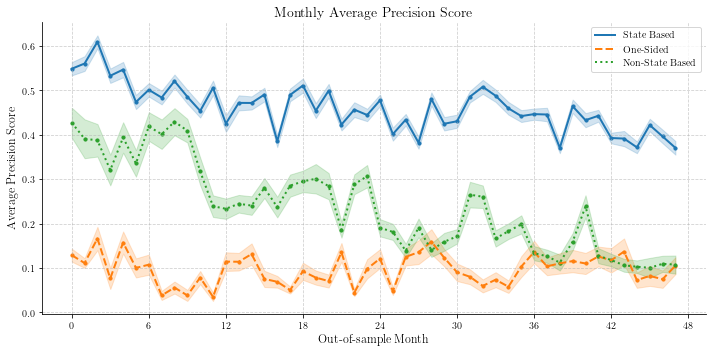

In [35]:
plot_monthly_ap(df)